# Step F7B: Dataset Statistics

## 1. Import required libraries

In [1]:
import pandas as pd
from datetime import datetime
import re
import numpy as np
import math
import os
import seaborn as sns

## 2. Read required data
*Read the different datasets used for each model in a dictionary*

In [2]:
data_df = {}
reddit_date_df = {}
twitter_date_df = {}

for i in range(1,5):
    
    model = f"model{i}"

    tick_list =  ['DKNG', 'TSLA', 'AMD', 'BABA', 'AMC']

    for tick in tick_list:
        
        if tick not in data_df:
            data_df[tick] = {}

        if model not in data_df[tick]:
            data_df[tick][model] = {}
        
        stock_df = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\{tick}_technical_data_df.pkl")

        reddit_sentiment_data = pd.DataFrame()
        twitter_sentiment_data = pd.DataFrame()
        
        if model=='model1':
            reddit_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\reddit_{tick}_BERT_TwitterAirline_Even.pkl")
            twitter_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\twitter_{tick}_BERT_TwitterAirline_Even.pkl")

        elif model == 'model2':
            reddit_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\reddit_{tick}_BERT_TwitterAirline_Uneven.pkl")
            twitter_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\twitter_{tick}_BERT_TwitterAirline_Uneven.pkl") 
            
        elif model == 'model3':
            reddit_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\reddit_{tick}_BERT_Sentiment140.pkl")
            twitter_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\twitter_{tick}_BERT_Sentiment140.pkl")
            
        elif model == 'model4':
            reddit_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\reddit_{tick}_finBERT.pkl")
            twitter_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\twitter_{tick}_finBERT.pkl")
        
        ymd_reddit = pd.DataFrame(list(reddit_sentiment_data['YearMonDay'].unique()), columns=['YearMonDay'])
        ymd_twitter = pd.DataFrame(list(twitter_sentiment_data['YearMonDay'].unique()), columns=['YearMonDay'])
        temp_ymd = pd.merge(pd.merge(ymd_reddit, ymd_twitter, how="inner", on="YearMonDay"), pd.DataFrame(stock_df.YearMonDay.unique(), columns=['YearMonDay']), on='YearMonDay')

        stock_df = pd.merge(stock_df, temp_ymd, how="inner", on="YearMonDay")

        temp_reddit_data = pd.merge(stock_df, reddit_sentiment_data, how="inner", on="YearMonDay")
        temp_twitter_data = pd.merge(stock_df, twitter_sentiment_data, how="inner", on="YearMonDay")

        #--Get the dates which will be used later for visualizations
        reddit_date_df[f'{tick}'] = temp_reddit_data['Date'].apply(lambda x: datetime.strftime(x, '%d-%m-%Y'))
        twitter_date_df[f'{tick}'] = temp_twitter_data['Date'].apply(lambda x: datetime.strftime(x, '%d-%m-%Y'))
        
        if model == 'model3':        
#             data_df[tick][model]['reddit'] = temp_reddit_data[['ACD','MACD','CHO','Highest_T','Lowest_T','S-K','S-D','VPT','W-R','RSI','MOME','AC','PROC','VROC','OBV','positive','negative','log_ret-t','Close']]
#             data_df[tick][model]['twitter'] = temp_twitter_data[['ACD','MACD','CHO','Highest_T','Lowest_T','S-K','S-D','VPT','W-R','RSI','MOME','AC','PROC','VROC','OBV','positive','negative','log_ret-t','Close']]
            data_df[tick][model]['reddit'] = temp_reddit_data[['positive','negative']]
            data_df[tick][model]['twitter'] = temp_twitter_data[['positive','negative']]

        else:
            data_df[tick][model]['reddit'] = temp_reddit_data[['positive','neutral','negative']]
            data_df[tick][model]['twitter'] = temp_twitter_data[['positive','neutral','negative']]            
            

## 3. Plot histograms
- *Plot the histograms of positive, negative and neutral values*
- *Save the plot as an image*

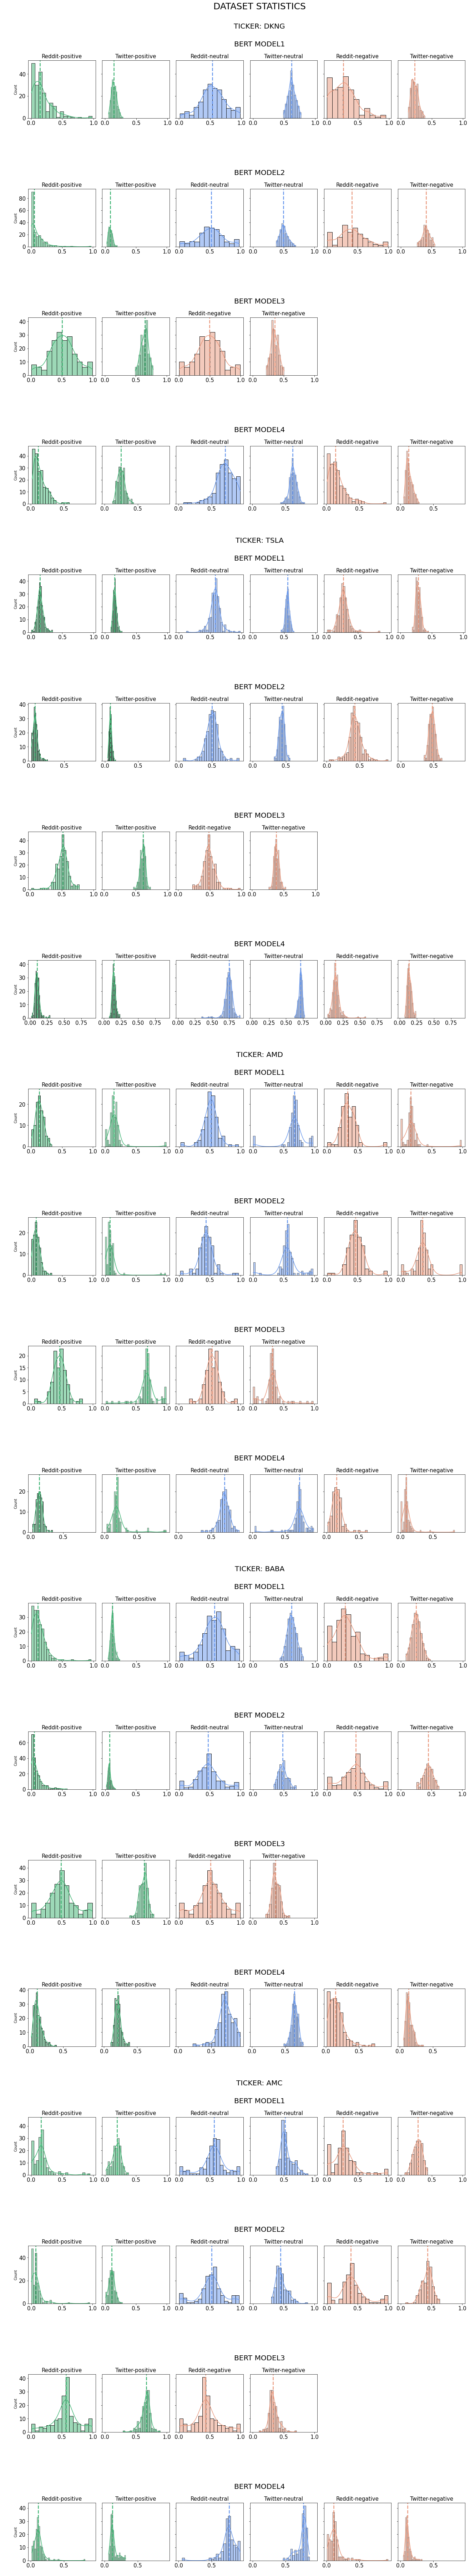

In [13]:
import matplotlib.pyplot as plt

# fig = plt.figure(constrained_layout=True, figsize=(40, 120))
fig = plt.figure(figsize=(20, 100))
fig.suptitle('DATASET STATISTICS', fontsize=25, fontweight=5, y=1)
subfigs = fig.subfigures(nrows=len(data_df), ncols=1, hspace = 0.0001)

subfig_no = 0

for tick, model_df in data_df.items():
#     print(tick)

    subfigs[subfig_no].suptitle(f'TICKER: {tick}', fontsize=20, y=0.96)
    
    lvl2_subfigs = subfigs[subfig_no].subfigures(nrows=len(model_df), ncols=1, hspace=0.0001)
    
    lvl2_subfig_no = 0

    #--plot for model1 data
    row_n = 0
    for model, tick_val in model_df.items():
#         print(model)
#         print('rown', row_n)
        ax = lvl2_subfigs[lvl2_subfig_no].subplots(nrows=1, ncols=6, sharey=True, sharex=True)
        lvl2_subfigs[lvl2_subfig_no].suptitle(f"BERT {model.upper()}", y=0.7, fontsize=20)
        
        df_col_num = len(tick_val['reddit'].columns)
        col_n=0
        
        for df_col in range(0, df_col_num):
#             print('coln', col_n)
#             print(col_name)
            
            col_name = tick_val['reddit'].iloc[:,df_col].name
            
            if col_name == 'positive':
                color='mediumseagreen'
            elif col_name == 'negative':
                color='darksalmon'
            else:
                color='cornflowerblue'
            
#             ax[col_n].hist(tick_val['reddit'][col_name], color = color, density=True, alpha=0.65)
            sns.histplot(x=tick_val['reddit'][col_name], color=color, kde=True, ax=ax[col_n])
            ax[col_n].set_title(f'Reddit-{col_name}', fontdict = {'fontsize' : 15})
            ax[col_n].axvline(x=tick_val['reddit'][col_name].median(), color=color, ls='--', lw=2.5)
            ax[col_n].set_xlabel('')
            ax[col_n].set_ylabel('Count', fontsize=10)
            ax[col_n].tick_params(axis='both', which='major', labelsize=15)
            

            col_n+=1
#             ax[col_n].hist(tick_val['twitter'][col_name], color = color, density=True, alpha=0.65)
            sns.histplot(x=tick_val['twitter'][col_name], color=color, kde=True, ax=ax[col_n])
            ax[col_n].set_title(f'Twitter-{col_name}', fontdict = {'fontsize' : 15})
            ax[col_n].axvline(x=tick_val['twitter'][col_name].median(), color=color, ls='--', lw=2.5)
            ax[col_n].set_xlabel('')
            ax[col_n].set_ylabel('Count', fontsize=10)
            ax[col_n].tick_params(axis='both', which='major', labelsize=15)
            
            col_n+=1
        
        if df_col_num == 2:
            ax[4].set_visible(False)
            ax[5].set_visible(False)
        
        lvl2_subfig_no+=1
    subfig_no+=1
    
    fig.subplots_adjust(left=0.05, bottom=0.1, right=None, top=0.55, wspace=0.1, hspace=0.2)

path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\'    
plt.savefig(f'{path}\Dataset_Statistics.jpg');
plt.show();

## 4. Correlation Plots

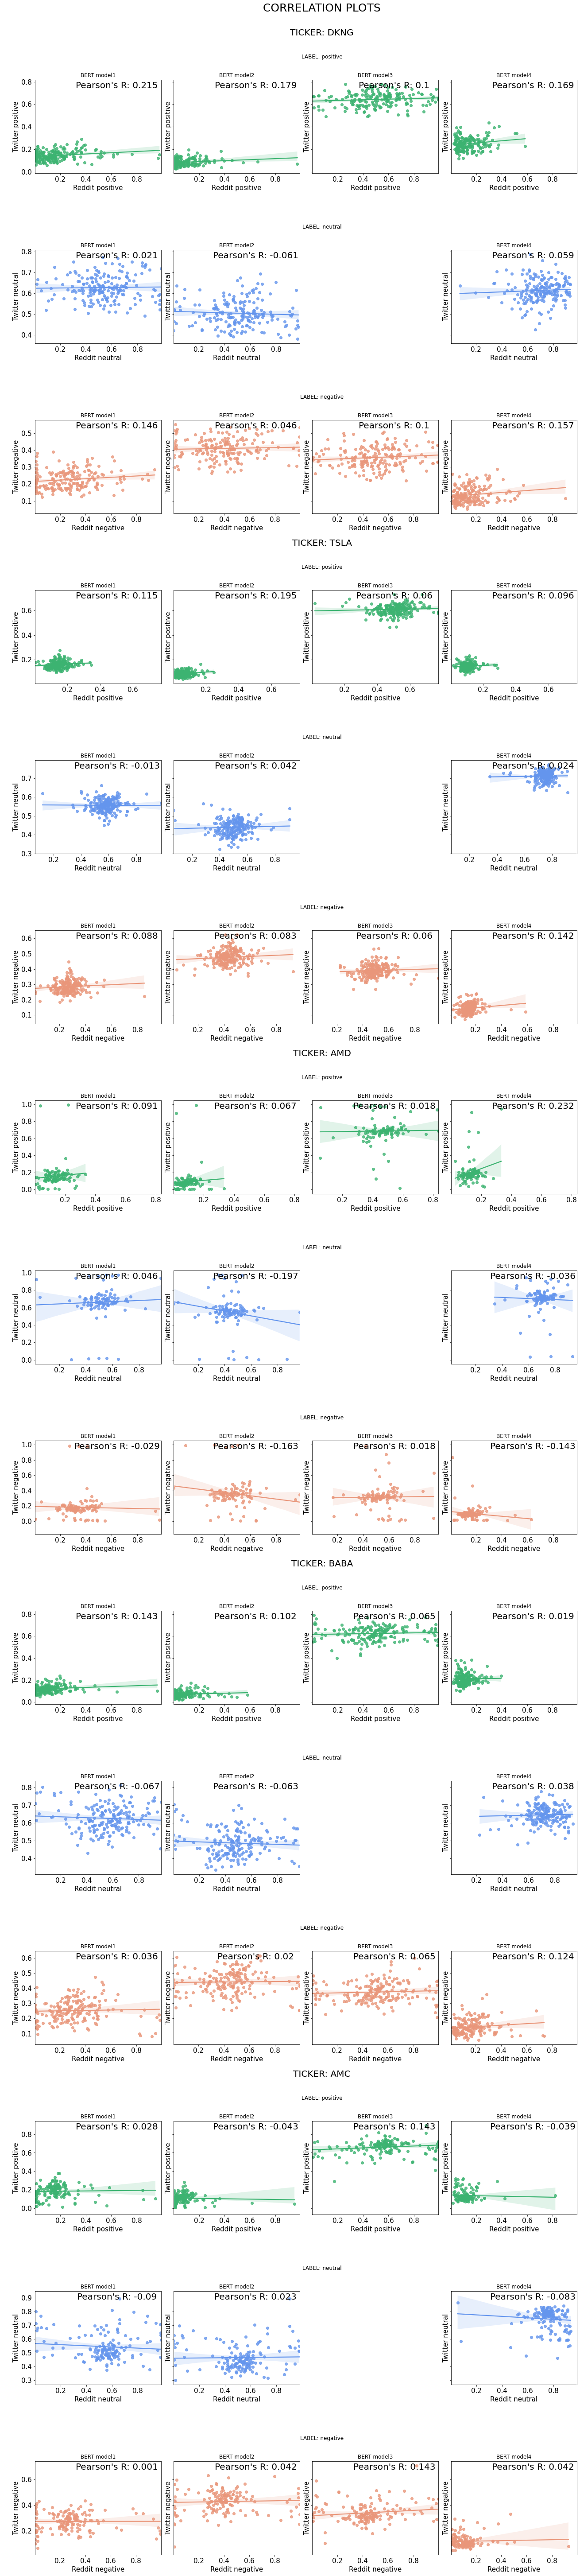

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\' 

# fig = plt.figure(constrained_layout=True, figsize=(40, 120))
fig = plt.figure(figsize=(20, 80))
fig.suptitle('CORRELATION PLOTS', fontsize=25, fontweight=5, y=1)

# num_tickers = len(data_df)
# num_models= 0
# max_num_labels =  0
# for tick, model_df in data_df.items():
#     tmp_mdl = len(model_df)
#     if tmp_mdl > num_models:
#         num_models=tmp_mdl
#     for model in model_df.values():
#         tmp_num = len(model['reddit'].columns)
#         if tmp_num > max_num_labels:
#             max_num_labels = tmp_num

            
tickers = []
models = []
labels = []
for tick, model_df in data_df.items():
    if tick not in tickers:
        tickers.append(tick) 
    for model, tick_df in model_df.items():
        if model not in models:
            models.append(model) 
        for label in tick_df['reddit'].columns.tolist():
            if label not in labels:
                labels.append(label) 
            

subfigs = fig.subfigures(nrows=len(tickers), ncols=1, hspace = 0.5)
subfig_no = 0

for ticker in tickers:
    subfigs[subfig_no].suptitle(f'TICKER: {ticker}', fontsize=20, y=0.95)
    
    lvl2_subfigs = subfigs[subfig_no].subfigures(nrows=len(labels), ncols=1, hspace=0.01)
    lvl2_subfig_no = 0
    
    for label in labels:
        lvl2_subfigs[lvl2_subfig_no].suptitle(f"LABEL: {label}", y=0.7)
        ax = lvl2_subfigs[lvl2_subfig_no].subplots(nrows=1, ncols=len(models), sharey=True, sharex=True)
        ax_col=0
        
        if label == 'positive':
            color='mediumseagreen'
        elif label == 'negative':
            color='darksalmon'
        else:
            color='cornflowerblue'
        
        
        for model in models:
            ax[ax_col].title.set_text(f'BERT {model}')
            if label in data_df[ticker][model]['reddit'].columns.tolist():
                reddit_data = data_df[ticker][model]['reddit'][label]
                twitter_data = data_df[ticker][model]['twitter'][label]
                pearsons_r = reddit_data.corr(twitter_data, method='pearson')
                
#                 ax[ax_col].scatter(reddit_data, twitter_data, alpha=0.5)
                sns.regplot(x=reddit_data, y=twitter_data, color=color, ax=ax[ax_col])
                ax[ax_col].text(0.65, 0.98, f'Pearson\'s R: {round(pearsons_r,3)}', horizontalalignment='center', verticalalignment='top', transform=ax[ax_col].transAxes, fontsize=20)
                ax[ax_col].set_xlabel(f'Reddit {label}', fontsize=15)
                ax[ax_col].set_ylabel(f'Twitter {label}', fontsize=15)
                ax[ax_col].tick_params(axis='both', which='major', labelsize=15)
            else:
                ax[ax_col].set_visible(False)

            ax_col+=1
        lvl2_subfig_no+=1

    subfig_no+=1
    fig.subplots_adjust(left=0.05, bottom=0.001, right=None, top=0.55, wspace=0.1, hspace=0.0002)
    
plt.savefig(f'{path}\Dataset_Label_Correlations.jpg', bbox_inches='tight');
plt.show();
    

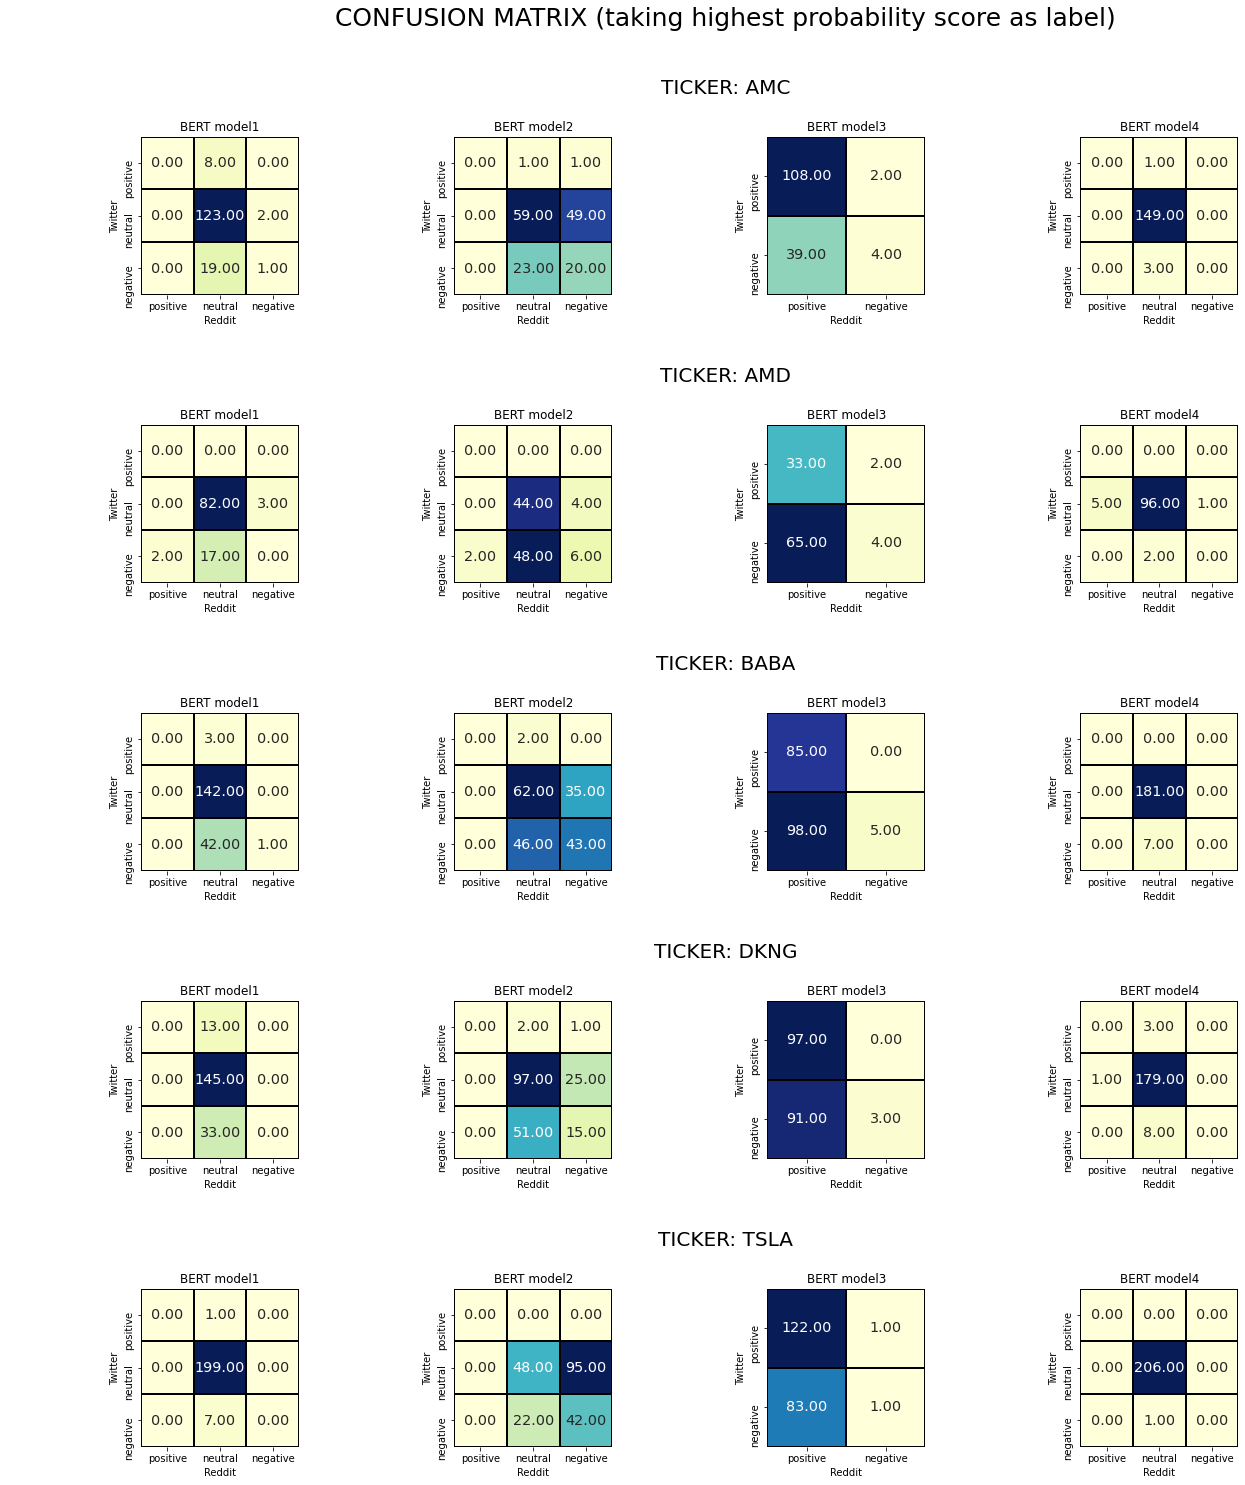

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\' 

# fig = plt.figure(constrained_layout=True, figsize=(40, 120))
fig = plt.figure(figsize=(20, 20))
fig.suptitle('CONFUSION MATRIX (taking highest probability score as label)', fontsize=25, fontweight=5, y=1)

tickers = []
models = []
labels = []
for tick, model_df in data_df.items():
    if tick not in tickers:
        tickers.append(tick) 
    for model, tick_df in model_df.items():
        if model not in models:
            models.append(model) 
        for label in tick_df['reddit'].columns.tolist():
            if label not in labels:
                labels.append(label) 
tickers.sort()                
            
subfigs = fig.subfigures(nrows=len(tickers), ncols=1, hspace = 0.5)
subfig_no = 0

for ticker in tickers:
    subfigs[subfig_no].suptitle(f'TICKER: {ticker}', fontsize=20, y=0.75)

    ax = subfigs[subfig_no].subplots(nrows=1, ncols=len(models), sharex=False, sharey=False)
    ax_col=0
    
    for model in models:
        reddit_data=None
        twitter_data=None
        ax[ax_col].title.set_text(f'BERT {model}')
        
        reddit_data = data_df[ticker][model]['reddit'].copy(deep=True)
        reddit_data['reddit_label'] = reddit_data.idxmax(axis="columns")
        twitter_data = data_df[ticker][model]['twitter'].copy(deep=True)
        twitter_data['twitter_label'] = twitter_data.idxmax(axis="columns")
        
        labels=None
        if len(reddit_data.columns.tolist()) == 4:
            labels=['positive', 'neutral', 'negative']
            
        else:
            labels=['positive', 'negative']
            
        cf_matrix = confusion_matrix(reddit_data['reddit_label'].astype(str), twitter_data['twitter_label'].astype(str), labels=labels)

        sns.heatmap(cf_matrix, ax=ax[ax_col], annot=True, annot_kws={'fontsize':"x-large"}, fmt='.2f', cmap="YlGnBu", cbar=False, xticklabels=labels, yticklabels=labels,linewidths=2,linecolor='black', square=True)
        ax[ax_col].set_xlabel('Reddit')
        ax[ax_col].set_ylabel('Twitter')
    
        ax_col+=1

    subfig_no+=1
    fig.subplots_adjust(left=0.05, bottom=0.001, right=None, top=0.55, wspace=0.1, hspace=0.002)
    

plt.savefig(f'{path}\Confusion Matrices.jpg', bbox_inches='tight');
plt.show();
    